<a href="https://colab.research.google.com/github/Adarsh0503/ROP-Detection/blob/main/MultispectralColor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install pandas keras numpy matplotlib scikit-learn tensorflow keras-applications

In [10]:
import pandas as pd
from keras.utils import to_categorical
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from glob import glob
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [11]:
zip1 = zipfile.ZipFile('/content/ImgConst_Using_HE.zip')
list1= zip1.namelist()
with zipfile.ZipFile('/content/ImgConst_Using_HE.zip',"r") as zip_ref:
    z1=zip_ref.extractall()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
pip install split-folders

In [14]:
import splitfolders
source_folder = '/content/ImgConst_Using_HE'


output_folder = 'split_data'


splitfolders.ratio(source_folder, output=output_folder, ratio=(0.7, 0.3))

print("Data splitting completed.")


# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import shutil  # Importing shutil for file management


# # Assuming your image files are in /content/MultispectralColor
# data_path = "/Users/mohammadshaad/Desktop/Everything/Early Detection of ROP/MultispectralColor"

# # Get all image paths
# all_image_paths = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]

# # Split data into training and testing sets (80% training, 20% testing)
# X_train, X_test = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# # Create the output folder if it doesn't exist
# output_folder = "split_data"
# os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# # Define subfolders for training and testing data
# train_subfolder = os.path.join(output_folder, "training")
# test_subfolder = os.path.join(output_folder, "testing")
# os.makedirs(train_subfolder, exist_ok=True)  # Create subfolders if needed
# os.makedirs(test_subfolder, exist_ok=True)

# # Move files to respective folders
# for image_path in X_train:
#     shutil.move(image_path, train_subfolder)

# for image_path in X_test:
#     shutil.move(image_path, test_subfolder)

# print("Data splitting and moving completed.")

Copying files: 91 files [00:00, 2459.29 files/s]

Data splitting completed.


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    strategy = tf.distribute.OneDeviceStrategy("/device:GPU:0")  # Use the first available GPU (T4 GPU)
else:
    strategy = tf.distribute.OneDeviceStrategy("/device:CPU:0")

In [16]:
with strategy.scope():
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_dir = '/content/split_data/train'
    test_dir = '/content/split_data/val'

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
    )

Found 62 images belonging to 4 classes.
Found 29 images belonging to 4 classes.


In [17]:
# InceptionV3 Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def InceptionV3Model():
  base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(4, activation='softmax')(x)  # Four classes: Stage 1, Stage 2, Stage 3, No ROP
  model = models.Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"InceptionV3 Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"InceptionV3 Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()


87910968/87910968 [==============================] - 5s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

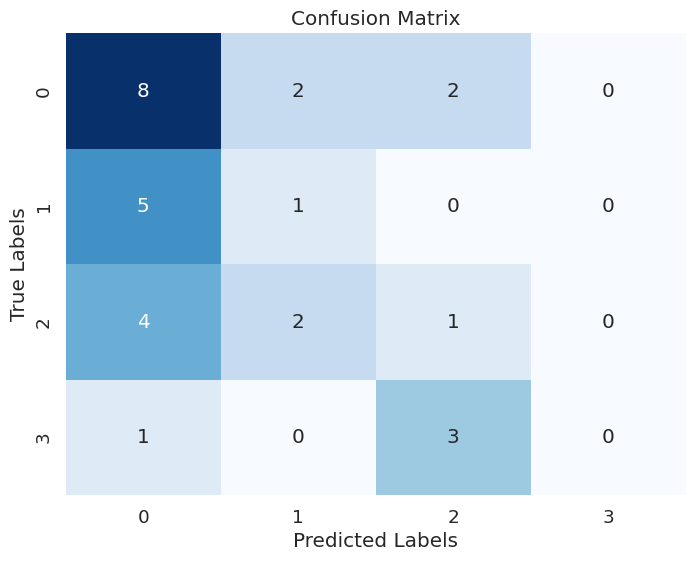

In [18]:
InceptionV3Model()

In [19]:
# ResNet50 Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def ResNet50Model():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(4, activation='softmax')(x)  # Four classes: Stage 1, Stage 2, Stage 3, No ROP
  model = models.Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"ResNet50 Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"ResNet50 Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()


94765736/94765736 [==============================] - 6s 0us/step


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

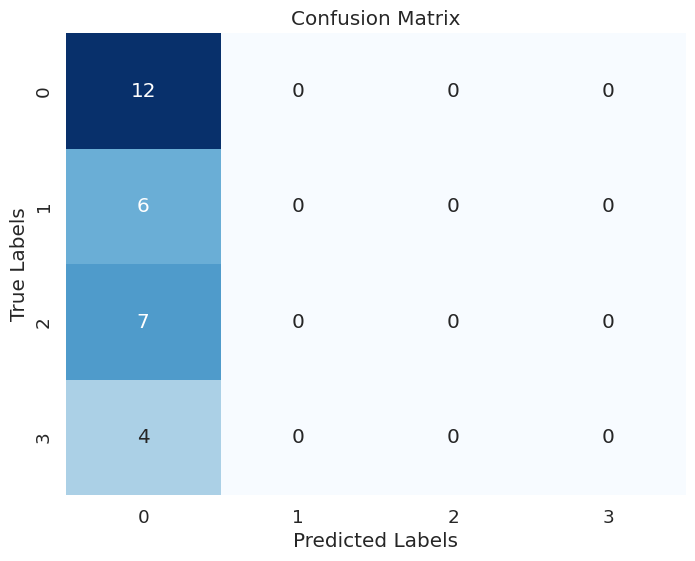

In [20]:
ResNet50Model()

In [21]:
# VGG16 Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def VGG16Model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = base_model.output
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(4, activation='softmax')(x)  # Four classes: Stage 1, Stage 2, Stage 3, No ROP
  model = models.Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"VGG16 Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"VGG16 Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

58889256/58889256 [==============================] - 3s 0us/step


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

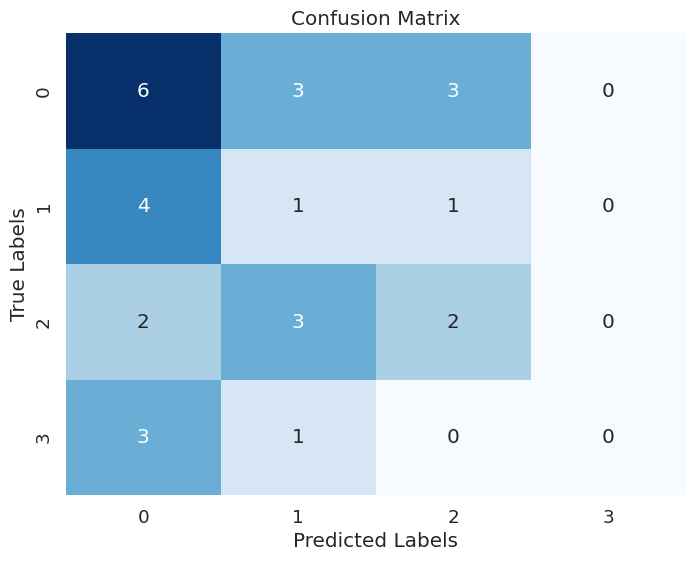

In [22]:
VGG16Model()

In [23]:
# VGG19 Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def VGG19Model():
  base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = base_model.output
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(4, activation='softmax')(x)  # Four classes: Stage 1, Stage 2, Stage 3, No ROP
  model = models.Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"VGG19 Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"VGG19 Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

80134624/80134624 [==============================] - 5s 0us/step


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

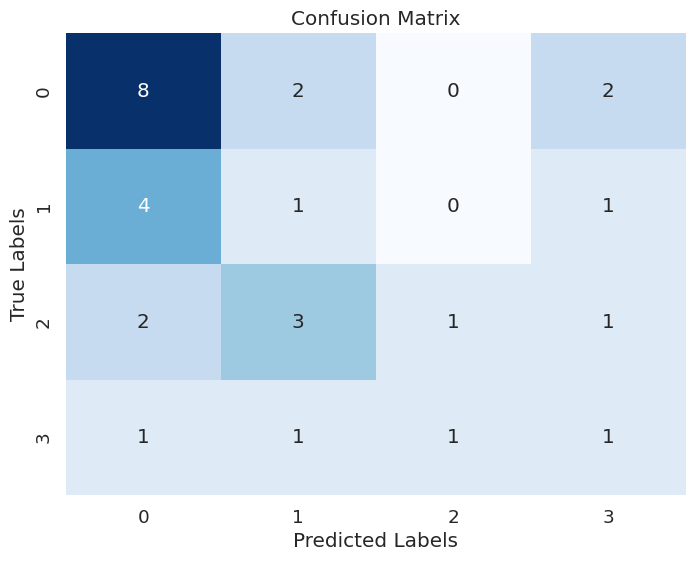

In [24]:
VGG19Model()

In [25]:
# DenseNet201 Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def DenseNet201Model():
  base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(4, activation='softmax')(x)  # Four classes: Stage 1, Stage 2, Stage 3, No ROP
  model = models.Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"DenseNet201 Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"DenseNet201 Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

74836368/74836368 [==============================] - 4s 0us/step


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

1/1 [==============================] - 4s 4s/step
Confusion Matrix:
[[7 2 3 0]
 [4 1 1 0]
 [5 2 0 0]
 [2 2 0 0]]


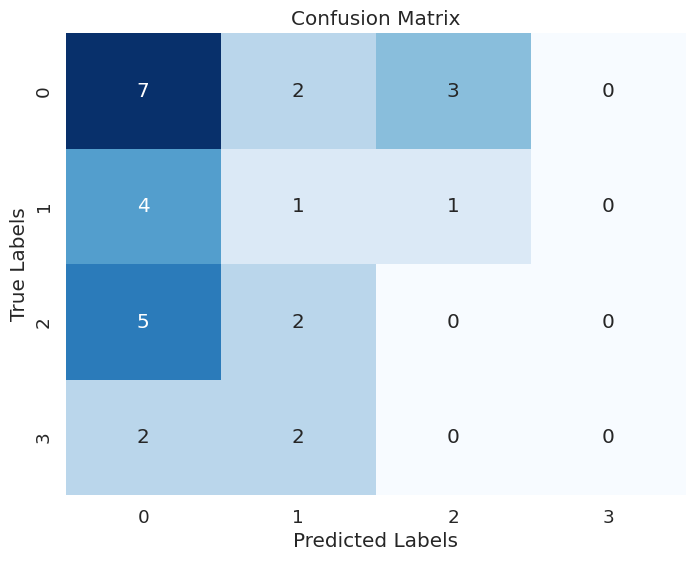

In [26]:
DenseNet201Model()

In [34]:
# MobileNet Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def MobileNetModel():
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in base_model.layers:
    layer.trainable = False
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(4, activation='softmax')(x)  # Four classes: Stage 1, Stage 2, Stage 3, No ROP
  model = models.Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()
  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"MobileNet Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"MobileNet Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

17225924/17225924 [==============================] - 2s 0us/step


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

1/1 [==============================] - 1s 774ms/step
Confusion Matrix:
[[6 2 4 0]
 [5 0 0 1]
 [7 0 0 0]
 [4 0 0 0]]


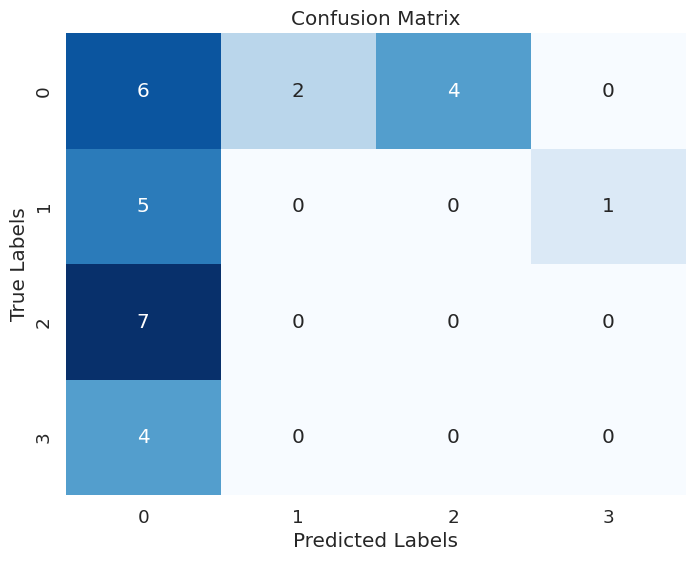

In [28]:
MobileNetModel()

In [29]:
# AlexNet Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def AlexNetModel():
  model = models.Sequential()

  model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
  model.add(layers.Conv2D(256, (5, 5), activation='relu'))
  model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
  model.add(layers.Conv2D(384, (3, 3), activation='relu'))
  model.add(layers.Conv2D(384, (3, 3), activation='relu'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))  # Four classes: Stage 1, Stage 2, Stage 3, No ROP

  model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.summary()

  r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))
  test_loss, test_accuracy = model.evaluate(test_generator)
  train_loss, train_accuracy = model.evaluate(train_generator)
  print(f"AlexNet Train Accuracy: {train_accuracy * 100:.2f}%")
  print(f"AlexNet Test Accuracy: {test_accuracy * 100:.2f}%")

  # Generate predictions
  predictions = model.predict(test_generator)
  # Convert predictions to class labels
  predicted_labels = np.argmax(predictions, axis=1)

  # Get actual labels
  actual_labels = test_generator.classes

  # Generate confusion matrix
  conf_matrix = confusion_matrix(actual_labels, predicted_labels)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust font scale
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 8, 8, 384)         885120    
                                                                 
 conv2d_97 (Conv2D)          (None, 6, 6, 384)         1

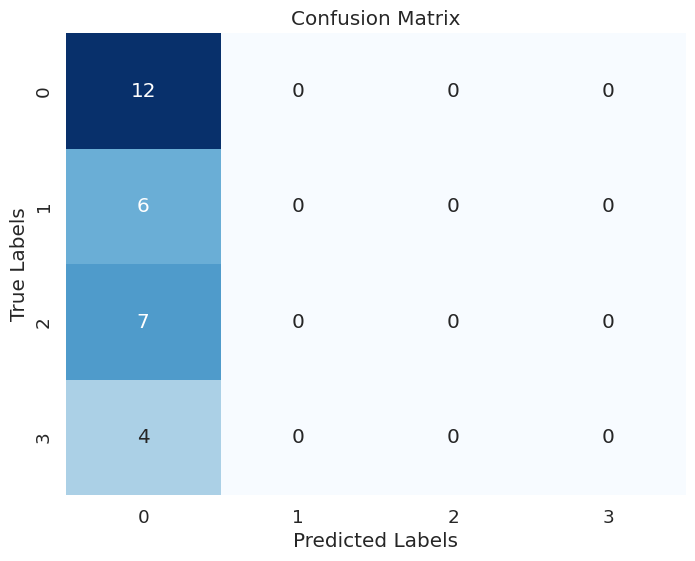

In [30]:
AlexNetModel()

1/1 [==============================] - 2s 2s/step
Confusion Matrix:
[[ 0 12  0  0]
 [ 0  6  0  0]
 [ 0  7  0  0]
 [ 0  4  0  0]]


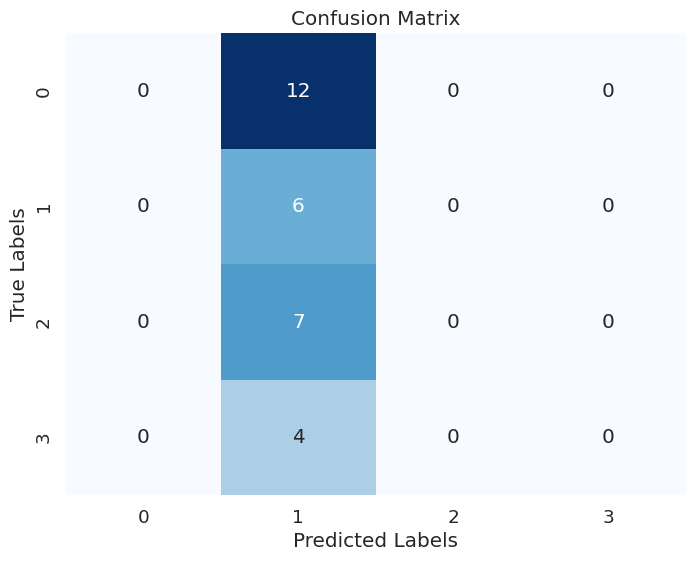

Epoch 1/10
2/2 [==============================] - 11s 5s/step - loss: 9.0470 - accuracy: 0.2097 - val_loss: 2.2820 - val_accuracy: 0.2414
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 1.9776 - accuracy: 0.2419 - val_loss: 1.3715 - val_accuracy: 0.2069
Epoch 3/10
2/2 [==============================] - 1s 839ms/step - loss: 1.3423 - accuracy: 0.3226 - val_loss: 1.3190 - val_accuracy: 0.4138
Epoch 4/10
2/2 [==============================] - 1s 859ms/step - loss: 1.3200 - accuracy: 0.4355 - val_loss: 1.2691 - val_accuracy: 0.4138
Epoch 5/10
2/2 [==============================] - 1s 889ms/step - loss: 1.2765 - accuracy: 0.4516 - val_loss: 1.2758 - val_accuracy: 0.4138
Epoch 6/10
2/2 [==============================] - 1s 901ms/step - loss: 1.2711 - accuracy: 0.4355 - val_loss: 1.2759 - val_accuracy: 0.4138
Epoch 7/10
2/2 [==============================] - 1s 884ms/step - loss: 1.2314 - accuracy: 0.4355 - val_loss: 1.2553 - val_accuracy: 0.4483
Epoch 8/10
2/2 [=========

In [31]:
# Define the CNN model within the strategy scope
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with strategy.scope():
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)  # 4 classes (No_ROP, Stage_1, Stage_2, Stage_3)

    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Generate predictions
    predictions = model.predict(test_generator)
    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get actual labels
    actual_labels = test_generator.classes

    # Generate confusion matrix
    conf_matrix = confusion_matrix(actual_labels, predicted_labels)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Train the model using the available GPU (T4 GPU)
with strategy.scope():
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        steps_per_epoch=len(train_generator),
        validation_steps=len(test_generator)
    )

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [32]:
from tensorflow.keras.applications import InceptionV3, MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Load and resize images from generators
def load_and_resize_images_from_generator(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        batch_images, batch_labels = generator.next()
        images.extend(batch_images)
        labels.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot encoded labels to integers
    return np.array(images), np.array(labels)

# Load images and labels from generators
X_train, y_train = load_and_resize_images_from_generator(train_generator)
X_test, y_test = load_and_resize_images_from_generator(test_generator)

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define the ensemble classifiers with reduced parameters
rf_clf = RandomForestClassifier(n_estimators=20, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=20, max_depth=5, random_state=42)
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)

# Train the individual classifiers
rf_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
gb_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
svm_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Combine predictions for soft voting
rf_pred_proba = rf_clf.predict_proba(X_test.reshape(X_test.shape[0], -1))
gb_pred_proba = gb_clf.predict_proba(X_test.reshape(X_test.shape[0], -1))
svm_pred_proba = svm_clf.predict_proba(X_test.reshape(X_test.shape[0], -1))

ensemble_pred_proba = (rf_pred_proba + gb_pred_proba + svm_pred_proba) / 3
ensemble_pred = np.argmax(ensemble_pred_proba, axis=1)

# Evaluate accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("Ensemble Accuracy:", ensemble_accuracy)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate confusion matrix for ensemble model
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_pred)

# Print confusion matrix for ensemble model
print("Ensemble Confusion Matrix:")
print(ensemble_conf_matrix)

# Plot confusion matrix for ensemble model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Ensemble Confusion Matrix')
plt.show()

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions for each CNN model
def InceptionV3Model(train_generator, test_generator):
    # Define and train the InceptionV3 model
    # ...

    # Generate predictions
    predictions = model.predict(test_generator)
    return predictions

def ResNet50Model(train_generator, test_generator):
    # Define and train the ResNet50 model
    # ...

    # Generate predictions
    predictions = model.predict(test_generator)
    return predictions

# Define functions for other CNN models (VGG16, VGG19, DenseNet201, MobileNet, AlexNet) similarly...

# Define ensemble model
def ensemble_model(predictions_list):
    # Combine predictions using voting
    ensemble_predictions = np.array(predictions_list)
    final_predictions = np.argmax(np.sum(ensemble_predictions, axis=0), axis=1)
    return final_predictions

# Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/split_data/train'
test_dir = '/content/split_data/val'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Generate predictions for each model
predictions_list = []
models = [InceptionV3Model, ResNet50Model]  # Add other models here
for model_func in models:
    predictions = model_func(train_generator, test_generator)
    predictions_list.append(predictions)

# Get actual labels
actual_labels = test_generator.classes

# Create ensemble predictions
ensemble_predictions = ensemble_model(predictions_list)

# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(actual_labels, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(actual_labels, ensemble_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
